# References

- [1] Superpositions, Sudoku, the Wave Function Collapse algorithm.
    - https://youtu.be/2SuvO4Gi7uY
    - [Martin Donald](https://www.youtube.com/c/MartinDonald)
- [2] Why I'm Using Wave Function Collapse for Procedural Terrain | Unity Devlog
    - https://youtu.be/20KHNA9jTsE
    - [DV Gen](https://www.youtube.com/channel/UCt9Rb0CWT8-bbsJtUOg6BsA)
- [3] Playing With The Wave Function Collapse Algorithm
    - https://youtu.be/GeBI9Bvo9oM
    - [Giant Bee](https://www.youtube.com/channel/UCMmnI7Fm3CglKF2AIpvGrLg)
- [4] How Townscaper Works: A Story Four Games in the Making | AI and Games
    - https://youtu.be/_1fvJ5sHh6A
    - [AI and Games](https://www.youtube.com/c/AIGamesSeries)
- [5] Wave Function Collapse Tutorial Unity (Playlist)
    - https://youtube.com/playlist?list=PLcRSafycjWFeKAS40OdIvhL7j-vsgE3eg
    - [Sunny Valley Studio](https://www.youtube.com/c/SunnyValleyStudio)
- [6] EPC2018 - Oskar Stalberg - Wave Function Collapse in Bad North
    - https://youtu.be/0bcZb-SsnrA
    - [BUas Games](https://www.youtube.com/channel/UC60WsaNESJpLHZ5Hjpuy7UQ)
- [7] Markov Chain based Wave Function Collapse
    - https://youtu.be/0W7yCuwlrbU
    - [Pronay Peddiraju](https://www.youtube.com/channel/UCZ6Pq8Ko3EUoVapphx8Pl0g)
- [8] Tile-Based Map Generation using Wave Function Collapse in 'Caves of Qud'
    - https://youtu.be/AdCgi9E90jw
    - [GDC](https://www.youtube.com/channel/UC0JB7TSe49lg56u6qH8y_MQ)
- [9] WaveFunctionCollapse is Constraint Solving in the Wild
    - https://adamsmith.as/papers/wfc_is_constraint_solving_in_the_wild.pdf
    - Isaac Karth, Adam M. Smith (2017)
- [10] Townscaper Announcement Trailer
    - https://youtu.be/QtVkteAS15M
    - [Raw Fury](https://www.youtube.com/channel/UCbyFV2lioP9a1YlUC4gm6xA)
- [11] Interactive Wave Function Collapse Demo
    - https://oskarstalberg.com/game/wave/wave.html
    - [Oskar Stålberg](oskarstalberg.com)
- [12] Original Wave Function Collapse GitHub Repo
    - https://github.com/mxgmn/WaveFunctionCollapse
    - [Maxim Gumin](https://github.com/mxgmn)
- [13] Procedural Generation with Wave Function Collapse
    - https://www.gridbugs.org/wave-function-collapse/
    - [Grid Bugs](https://www.gridbugs.org/)

# Code

In [ ]:
%matplotlib notebook

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from copy import deepcopy
from pprint import pprint
from pathlib import Path
import cv2
from collections import defaultdict
import time

In [ ]:
choice = np.random.choice

# 1D

In [ ]:
def show_line(Line):
    %matplotlib inline
    plt.axis('off')
    plt.imshow([Line])

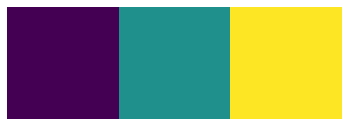

In [ ]:
show_line([1, 2, 3])

In [ ]:
def animate_lines(Lines):
    %matplotlib notebook
    fig, ax = plt.subplots()
    ax.axis('off')
    img = ax.imshow([Lines[-1]], animated=True)
    
    def animate(frame, *fargs):
        img.set_data([frame])
        
    return animation.FuncAnimation(fig, animate, frames=Lines, interval=500, repeat=True)

<IPython.core.display.Javascript object>


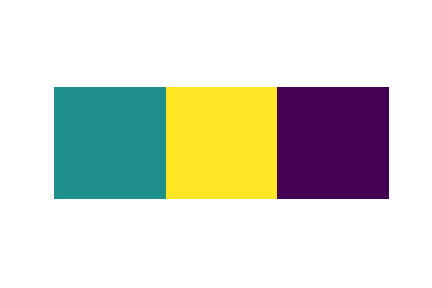

In [ ]:
animate_lines([
    [0, 0, 0],
    [1, 2, 3],
    [2, 3, 1],
    [3, 1, 2],
]);

### Complete Wave Function Collapse 1D

In [ ]:
def D1_WaveFunctionCollapse(N, PossibleValuesRules) -> (list, list):
    AllLines = list()
    NumberOfPossibleValues = len(PossibleValuesRules)
    PossibleValues         = list(PossibleValuesRules.keys())
    PossibleValuesIdxs     = np.arange(NumberOfPossibleValues)
    Line             = np.zeros(shape=N, dtype=int)
    AllLines.append(deepcopy(Line))
    WaveFunction     = np.ones(shape=(N, NumberOfPossibleValues), dtype=bool)
    LineHasCollapsed = np.zeros(shape=N, dtype=bool)
    
    X = choice(N) # Choose initial cell to collapse
    while True:
        PossibleIdxForX = PossibleValuesIdxs[WaveFunction[X]]
        assert len(PossibleIdxForX) > 0
        ChoiceIdxForX   = choice(PossibleIdxForX) # Choose what value to collapse to, among the remaining possible ones.
        Line[X]         = PossibleValues[PossibleValuesIdxs[ChoiceIdxForX]] # Apply choice to cell
        AllLines.append(deepcopy(Line))
        
        LineHasCollapsed[X] = True
        WaveFunction[X]     = False # numpy broadcasting
        
        WaveFunctionHasChanged = True
        while WaveFunctionHasChanged: # execute at least once
            WaveFunctionHasChanged = False
            for i in range(0, N):
                if LineHasCollapsed[i]:
                    # print(f'{i} Collapsed')
                    continue # Dont update the wavefunction of a cell that has already collapsed
                CurrentElement      = Line[i]
                CurrentWaveFunction = WaveFunction[i]
                NewWaveFunction     = np.ones_like(CurrentWaveFunction)
                
                def check_element(idx):
                    "Checks what values are permitted at the current element, based on what is present at this neighboor."
                    OtherElement, OtherWaveFunction = Line[idx], WaveFunction[idx]
                    if LineHasCollapsed[idx]:
                        AllowedValues = PossibleValuesRules[OtherElement]
                    else:
                        AllowedValues = [Value for (V, W) in zip(PossibleValues, OtherWaveFunction) for Value in PossibleValuesRules[V] if W]
                    for ValueIdx, Value in enumerate(PossibleValues):
                        if Value in AllowedValues:
                            # if another cell has already made this value impossible, it can't be made possible again here.
                            NewWaveFunction[ValueIdx] &= True
                        else:
                            NewWaveFunction[ValueIdx] = False

                if i > 0  : check_element(i-1)
                if i < N-1: check_element(i+1)
                NumberOfPossibleValues = sum(NewWaveFunction)
                assert NumberOfPossibleValues != 0, f'{i} {WaveFunction}'
                if NumberOfPossibleValues == 1: # Collapse this element
                    Line[i]                = PossibleValues[PossibleValuesIdxs[NewWaveFunction][0]]
                    AllLines.append(deepcopy(Line))
                    LineHasCollapsed[i]    = True
                    WaveFunction[i]        = False # numpy broadcasting
                    WaveFunctionHasChanged = True
                else:
                    WaveFunction[i] = NewWaveFunction
                    WaveFunctionHasChanged |= any(CurrentWaveFunction != NewWaveFunction)
                # print(i, CurrentWaveFunction, NewWaveFunction)
        
        NumberOfPossibleStates = WaveFunction.sum(axis=1)
        # Get the field with the lowest number of non-zero (non-collapsed) states.
        # If there are multiple fields, pick one of those at random.
        RemainingUncertainFields = np.flatnonzero(LineHasCollapsed == False)
        if len(RemainingUncertainFields) == 0: break # STOP condition
        
        # There are two way of calculating what the number of least, non-zero, possibilities is:
        # LeastNumberOfRemainingStates = np.min(NumberOfPossibleStates,
        #                                       where=(LineHasCollapsed == False),
        #                                       initial=NumberOfPossibleValues)

        LeastNumberOfRemainingStates = np.min(NumberOfPossibleStates[RemainingUncertainFields])

        # Choose which cell to collapse next
        X = choice(np.flatnonzero(NumberOfPossibleStates == LeastNumberOfRemainingStates))
    return Line, AllLines

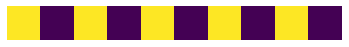

In [ ]:
N = 10
# PossibleValuesRules = {
#     0: (1, 3,),
#     1: (0,),
#     2: (1,),
#     3: (2,3)
# }
PossibleValuesRules = {
    0: (1,),
    1: (0,),
}
Line, AllLines = D1_WaveFunctionCollapse(N, PossibleValuesRules)
show_line(Line)
# animate_lines(AllLines);

In [ ]:
AllLines

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])]

# 2D

### Visualization

In [ ]:
# TODO: replace matplotlib image show with something else, something more flexible. Maybe custom rendering via opencv

In [ ]:
def show_image(Image, GridLines:int=0, LineColor:str='black'):
    """
    Shows an Image.
    
    Parameters
    ----------
    Image     : The Image to be shown in the form of a numpy Matrix
    GridLines : The number of pixels between each gridline in the X and Y direction. 0 turns off the grid an axis.
    LineColor : The color of the gridlines. Only used if GridLines is > 0
    """
    %matplotlib inline
    plt.imshow(Image)
    if not GridLines:
        plt.axis('off')
    else:
        plt.xticks(np.arange(-.5, Image.shape[1], GridLines))
        plt.yticks(np.arange(-.5, Image.shape[0], GridLines))
        plt.grid(color=LineColor, linewidth=4)

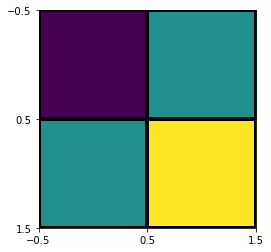

In [ ]:
show_image(np.array([[1, 2], [2, 3]]), GridLines=1)

In [ ]:
def animate_images(Images:list, GridLines:int=0, LineColor:str='black', interval:int=500):
    """
    Animates a list of Images as a repeating sequence.
    
    Parameters
    ----------
    Images    : A list of Images in the form of numpy Matrices
    GridLines : The number of pixels between each gridline in the X and Y direction. 0 turns off the grid an axis.
    LineColor : The color of the gridlines. Only used if GridLines is > 0
    interval  : The time between frames in milliseconds
    """
    %matplotlib notebook
    fig, ax = plt.subplots()
    img = ax.imshow(Images[-1], animated=True)
    if not GridLines:
        ax.axis('off')
    else:
        # TODO: For some stupid reason, the gridlines only work under specific circumstances
        ax.set_xticks(np.arange(-.5, Images[-1].shape[1], GridLines))
        ax.set_yticks(np.arange(-.5, Images[-1].shape[0], GridLines))
        ax.grid(color=LineColor, linewidth=4)
    
    def animate(frame, *fargs):
        img.set_data(frame)
    
    return animation.FuncAnimation(fig, animate, frames=Images, interval=interval, repeat=True)

<IPython.core.display.Javascript object>


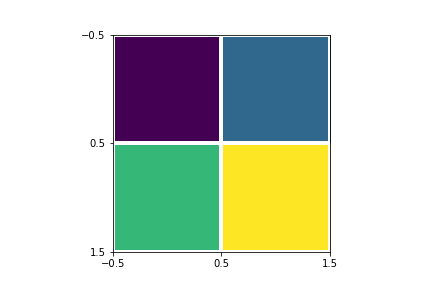

In [ ]:
animate_images(np.array([
    [[0, 0], [0, 0]],
    [[0, 0], [0, 1]],
    [[0, 0], [1, 2]],
    [[0, 1], [2, 3]],
    [[1, 2], [3, 4]],
]), GridLines=1, LineColor='white');

In [ ]:
def save_animation(path, fps, dpi, anim):
    "Save an animation created with `animate_images` to disk."
    anim.save(path, writer=animation.PillowWriter(fps=fps), dpi=dpi)

In [ ]:
# Convert a Wave Function to a render-able Image

def assemble_tiles(IntermediateImage):
    "Takes in a N x M x V x W x *_ Matrix and reshapes it to N*V x M*W x *_. "\
    "Basically it assembles a bunch of image patches into one image."
    return np.hstack(np.hstack(IntermediateImage))

def ImageFromPartialWaveFunction(N:int, M:int, Wave, TileMatrix, AsType:type=float):
    "Generate an Image from a partially collapsed WaveFunction by averaging over possible Tiles"
    ImageW = [[list() for _ in range(M)] for _ in range(N)] # N x M x Variable dimensional list
    for (X, Y, Vs) in np.argwhere(Wave):
        ImageW[X][Y].append(TileMatrix[Vs])
    ImageW2 = np.array([[np.mean(L2, axis=0) for L2 in L1] for L1 in ImageW]) # Average over the variable dimension
    ImageW3 = assemble_tiles(ImageW2)
    if AsType != int and np.max(ImageW3) > 2: print('Warning: Clipping values to 0-1. Did you mean to use AsType=int?')
    return ImageW3.astype(AsType)

def ImageFromCollapsedWaveFunction(N:int, M:int, Wave, TileMatrix, AsType:type=float):
    "Generate an Image from a collapsed WaveFunction."
    _, _, ImageValues = np.nonzero(Wave)
    assert ImageValues.shape == (N * M,)
    TileIndices = ImageValues.reshape(N, M)
    Image = assemble_tiles(TileMatrix[TileIndices])
    return Image.astype(AsType)

In [ ]:
def save_result(ROOT, SamplePath, TileSize, N, M, AllWaves):
    ResultsPath = ROOT/'Results'
    ResultsPath.mkdir(parents=True, exist_ok=True)
    FileName = f'{SamplePath.stem}_{TileSize}_{N}x{M}_{time.time_ns()}.npy'
    FilePath = ResultsPath/FileName
    np.save(FilePath, np.array(AllWaves), allow_pickle=False)
    return FilePath

### Verify and Convert Rules

In [ ]:
def verify_rules_2D(Rules):
    for k, v in Rules.items():
        for Direction, AllowedValues in v.items():
            OppositeDirection = {'U':'D', 'D':'U', 'L':'R', 'R':'L'}[Direction]
            for Value in AllowedValues:
                assert (k in Rules[Value][OppositeDirection]), \
                f'{k} "{Direction}" allows {AllowedValues}, '\
                f'but {Value} "{OppositeDirection}" only allows {Rules[Value][OppositeDirection]}'

In [ ]:
def verify_rules_matrix_2D(RulesMatrix):
    OppositeDirection = {2:3, 3:2, 0:1, 1:0}
    for (ThisTile, TileRules) in enumerate(RulesMatrix):
        for (Direction, Rule) in enumerate(TileRules):
            for (OtherTile, IsAllowed) in enumerate(Rule):
                OtherDirection = OppositeDirection[Direction]
                OtherRule      = RulesMatrix[OtherTile][OtherDirection]
                OtherIsAllowed = OtherRule[ThisTile]
                assert IsAllowed == OtherIsAllowed, \
                f'Tile {ThisTile} and Tile {OtherTile} disagree on whether they can be next to each other.\n\t\t' \
                f'The Rule values should be identical at the following directions and indices:\n\t\t'\
                f'Tile {ThisTile} in direction {Direction} at index {OtherTile}, and '\
                f'Tile {OtherTile} in direction {OtherDirection} at index {ThisTile}:\n\t\t'\
                f'Tile {ThisTile}{[Direction]}: {Rule}[{OtherTile}] = {IsAllowed}\n\t\t'\
                f'Tile {OtherTile}{[OtherDirection]}: {OtherRule}[{ThisTile}] = {OtherIsAllowed}'

In [ ]:
def _rule_to_vector(TileAmount, Rule):
    return [(i in Rule) for i in range(TileAmount)]
def rules_to_np(Rules):
    TileAmount = len(Rules)
    return np.array([[_rule_to_vector(TileAmount, Rules[i][d]) for d in ('L', 'R', 'U', 'D')] for i in range(TileAmount)])

### Helper

In [ ]:
def Neighbours(X:int, Y:int, N:int, M:int) -> (int, int, int):
    """
    Generates a list of neighbouring coordinates for any cell on a grid.
    
    Parameters
    ----------
    X : The current X coordinate
    Y : The current Y coordinate
    N : The length of the Grid in X direction (shape[0])
    M : The length of the Grid in Y direction (shape[1])
    
    Returns
    -------
    D : The Direction you need to go to get back to the original coordinates.
        Left = 0 | Right = 1 | Up = 2 | Down = 3
    K : The X coordinate of the neighbour
    J : The Y coordinate of the neighbour
    """
    # {'L':0,'R':1,'U':2,'D':3}
    if (X - 1) >= 0      : yield (3, X - 1, Y    ) # 'D'
    if (X + 1) <= (N - 1): yield (2, X + 1, Y    ) # 'U'
    if (Y - 1) >= 0      : yield (1, X    , Y - 1) # 'R'
    if (Y + 1) <= (M - 1): yield (0, X    , Y + 1) # 'L'
# set(Neighbours(3, 1, 10, 10))

## Complete 2D WFC

In [ ]:
def WFC_2D(N:int, M:int, RulesMatrix):
    Wave = np.ones (shape=(N, M, len(RulesMatrix)), dtype=bool)
    X, Y = choice(N), choice(M) # Initial Cell Choice
    # NOTE: Currently we don't treat the edge in and special way
    while True:
        # NOTE: Assign a Tile (from those available at this cell) to chosen Cell
        TileChoice              = choice(np.flatnonzero(Wave[X, Y])) # This assumes Tiles are stored/indexed like a list
        Wave [X, Y]             = False # Numpy Broadcasting
        Wave [X, Y][TileChoice] = True # This is used in the floodfill part to figure out what rules apply
        # NOTE: Floodfill to update all Cells whose Neighbours have changed
        CellsToCheck = set(Neighbours(X, Y, N, M))
        while len(CellsToCheck) > 0:
            NewCellsToCheck = set()
            for (_, K, J) in CellsToCheck:
                # NOTE: Check all Rules of this Cell, and modify Wave accordingly.
                CurrentWave    = Wave[K, J] # shape: (NumberOfTiles,)
                if CurrentWave.sum() <= 1: continue # Only one remaining state -> this cell is already collapsed
                CurrentWaveNew = np.ones_like(CurrentWave)
                for (D, U, V) in Neighbours(K, J, N, M):
                    # NOTE: Which Tiles does this neighbouring Cell allow to be placed at the original Cell?
                    OtherConstraint = RulesMatrix[np.flatnonzero(Wave[U, V])][:, D].any(axis=0)
                    # Logical AND -> one neighbour disallowing a Tile means that Tile cant be used at all in current Cell
                    CurrentWaveNew &= OtherConstraint
                if np.sum(CurrentWaveNew) == 0: raise Exception(f'Arrived at an unsolvable solution. {K, J}')
                if np.any(CurrentWave != CurrentWaveNew):
                    NewCellsToCheck.update(Neighbours(K, J, N, M))
                Wave[K, J] = CurrentWaveNew
            CellsToCheck = NewCellsToCheck
        CellEntropy = Wave.sum(axis=-1) # Number of remaining States per cell
        if np.all(CellEntropy == 1): break # STOP Condition
        yield deepcopy(Wave)
        # NOTE: Select next Cell based on lowest Entroy
        LowestUncollapsedEntropy = np.min(CellEntropy[CellEntropy != 1])
        assert LowestUncollapsedEntropy > 1, f'1 means the cell should already be collapsed, and < 0 should be impossible.'
        OptionsForNextCell = np.argwhere(CellEntropy == LowestUncollapsedEntropy) # Un-collapsed Cells with the lowest Entropy
        X, Y = OptionsForNextCell[choice(len(OptionsForNextCell))]
    yield Wave

### Work in Progress

In [ ]:
def WFC_2D(N:int, M:int, RulesMatrix):
    Wave = np.ones (shape=(N, M, len(RulesMatrix)), dtype=bool)
    X, Y = choice(N), choice(M) # Initial Cell Choice
    # TODO: Do a pre-pass here to handle global conditions? What if a tile can't be placed at the edge?
    # NOTE: Currently we don't treat the edge in and special way
    while True:
        # NOTE: Assign a Tile (from those available at this cell) to chosen Cell
        TileChoice              = choice(np.flatnonzero(Wave[X, Y])) # This assumes Tiles are stored/indexed like a list
        Wave [X, Y]             = False # Numpy Broadcasting
        Wave [X, Y][TileChoice] = True # This is used in the floodfill part to figure out what rules apply
        # NOTE: Floodfill to update all Cells whose Neighbours have changed
        CellsToCheck = set(Neighbours(X, Y, N, M))
        while len(CellsToCheck) > 0:
            NewCellsToCheck = set()
            for (_, K, J) in CellsToCheck:
                # NOTE: Check all Rules of this Cell, and modify Wave accordingly.
                CurrentWave    = Wave[K, J] # shape: (NumberOfTiles,)
                if CurrentWave.sum() <= 1: continue # Only one remaining state -> this cell is already collapsed
                CurrentWaveNew = np.ones_like(CurrentWave)
                # TODO: Technically we only need to check this for neighbours that have changed,
                #       but keeping track of that seems like it might be more effort than just checking all neighbours.
                # TODO: This loop can also be done in numpy
                print(f'Checking cell: {(K, J)}')
                CurrentNeighbours = np.array(list(Neighbours(K, J, N, M))) # 0 is the directions, 1 and 2 are the coordinates
                NeighboursDOrigin = CurrentNeighbours[:, 0]
                NeighboursX       = CurrentNeighbours[:, 1]
                NeighboursY       = CurrentNeighbours[:, 2]
                # print('Coordinates and direction back to original for all Neighbours:\n', CurrentNeighbours)
                NeighboursWave    = Wave[NeighboursX, NeighboursY]
                # print('Wave Functions of all Neighbours:\n', NeighboursWave)
                NonZeroNeighboursWave = np.nonzero(NeighboursWave)
                NeighbourIndexForNonZeroWaveValues, NonZeroWaveValueIndexForNeibours = NonZeroNeighboursWave
                print('Coordinates for all Non-Zero Values in Wave Functions of the Neighbours:\n', NonZeroNeighboursWave)
                RuleDirections = NeighboursDOrigin[NeighbourIndexForNonZeroWaveValues]
                print('Directions to check rules in for each non-zero possible neighbour:\n', RuleDirections, RuleDirections.shape)
                # print('Rules:\n', RulesMatrix)
                AllNonZeroRules = RulesMatrix[NonZeroWaveValueIndexForNeibours]
                # print('Rules for all the non-zero tiles from each neighbour:\n', AllNonZeroRules)
                NonZeroRules = AllNonZeroRules[np.arange(len(NonZeroWaveValueIndexForNeibours)), RuleDirections, :]
                print('Rules for non-zero tiles, in the direction of the original tile:\n', NonZeroRules)
                
                for (D, U, V) in Neighbours(K, J, N, M):
                    # NOTE: Which Tiles does this neighbouring Cell allow to be placed at the original Cell?
                    OtherConstraint = RulesMatrix[np.flatnonzero(Wave[U, V])][:, D].any(axis=0)
#                     print(np.flatnonzero(Wave[U, V]))
#                     print(RulesMatrix[np.flatnonzero(Wave[U, V])][:, D], D)
#                     print(CurrentWaveNew, OtherConstraint)
                    # Logical AND -> one neighbour disallowing a tile means that tile cant be used at all in current cell
                    CurrentWaveNew &= OtherConstraint
                if np.sum(CurrentWaveNew) == 0: raise Exception(f'Arrived at an unsolvable solution. {K, J}')
                if np.any(CurrentWave != CurrentWaveNew):
                    NewCellsToCheck.update(Neighbours(K, J, N, M))
                Wave[K, J] = CurrentWaveNew
                print(CurrentWaveNew)
                print('-----------------------------------------------')
            CellsToCheck = NewCellsToCheck
        CellEntropy = Wave.sum(axis=-1) # Number of remaining States per cell
        if np.all(CellEntropy == 1): break # STOP Condition
        yield deepcopy(Wave)
        # NOTE: Select next Cell based on lowest Entroy
        LowestUncollapsedEntropy = np.min(CellEntropy[CellEntropy != 1])
        assert LowestUncollapsedEntropy > 1, f'1 means the cell should already be collapsed, and < 0 should be impossible.'
        OptionsForNextCell = np.argwhere(CellEntropy == LowestUncollapsedEntropy) # Un-collapsed Cells with the lowest Entropy
        X, Y = OptionsForNextCell[choice(len(OptionsForNextCell))]
    yield Wave

__At the core of the WFC Collapse implementation is this loop:__
```python
for (D, U, V) in Neighbours(K, J, N, M):
    OtherConstraint = RulesMatrix[np.flatnonzero(Wave[U, V])][:, D].any(axis=0)
    CurrentWaveNew &= OtherConstraint
```
- __It checks for each Neighbour of a Cell, which Tiles are allowed at that Cell based on the Rules, and the current state of `Wave`.__  

- __I thought having a python loop at the very core of your algorithm can be a bottleneck, even if that loop only loops for 2 - 4 times each time it's executed, so here is an attempt at removing it, by using numpy to do this calculation for all neighbours at the same time.__  
- __If this succeeds I can probably remove the next loop up as well, and do the calculation for all `CellsToCheck` at once using numpy.__

```python
CurrentNeighbours     = np.array(list(Neighbours(K, J, N, M))) # 0 = directions, 1,2 = coordinates
NeighboursDOrigin     = CurrentNeighbours[:, 0]
NeighboursX           = CurrentNeighbours[:, 1]
NeighboursY           = CurrentNeighbours[:, 2]
NeighboursWave        = Wave[NeighboursX, NeighboursY]
NonZeroNeighboursWave = np.nonzero(NeighboursWave)
NeighbourIndexForNonZeroWaveValues, NonZeroWaveValueIndexForNeibours = NonZeroNeighboursWave
RuleDirections  = NeighboursDOrigin[NeighbourIndexForNonZeroWaveValues]
AllNonZeroRules = RulesMatrix[NonZeroWaveValueIndexForNeibours]
NonZeroRules    = AllNonZeroRules[np.arange(len(NonZeroWaveValueIndexForNeibours)), RuleDirections, :]
```
__After Refactoring:__
```python
CurrentNeighbours     = np.array(list(Neighbours(K, J, N, M))) # 0 = directions, 1,2 = coordinates
CND, CNX, CNY         = CurrentNeighbours[:, 0], CurrentNeighbours[:, 1], CurrentNeighbours[:, 2]
NonZeroNeighboursWave = np.nonzero(Wave[CNX, CNY])
NonZeroRules = RulesMatrix[NonZeroNeighboursWave[1]][np.arange(len(NonZeroNeighboursWave[1])),
                                                     CND[NonZeroNeighboursWave[0]],
                                                     :]
```
__After Refactoring Again:__
```python
N            = np.array(list(Neighbours(K, J, N, M))) # 0 = directions, 1,2 = coordinates
D, Xn, Yn    = N[:, 0], N[:, 1], N[:, 2]
V, W         = np.nonzero(Wave[Xn, Yn])
NonZeroRules = RulesMatrix [W] [np.arange(len(W)), D[V], :]
```

__At this point it's not done yet though, we still need the `.any()` step and the `&=` from the previous implementation.__  

__The Problem is, this again requires a lot of indexing / unrolling of a loop, at which point it becomes way too much work compared with just using the python loop.__

In [ ]:
# Warning: This cell produces a lot of output, so clear it before making a commit.
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))
AllWaves = [ImageFromPartialWaveFunction(N, M, W, TilesMatrix) for W in AllWaves]

## Here are three different ways of using the WFC Algorithm.

### Define Tiles and Rules Manually

In [ ]:
Tiles = [
    [[0, 1], [0, 0]],
    [[0, 0], [1, 1]],
    [[1, 0], [1, 0]],
    [[0, 0], [0, 0]],
]
TilesMatrix = np.array(Tiles); TilesMatrix.shape, TilesMatrix

((4, 2, 2),
 array([[[0, 1],
         [0, 0]],
 
        [[0, 0],
         [1, 1]],
 
        [[1, 0],
         [1, 0]],
 
        [[0, 0],
         [0, 0]]]))

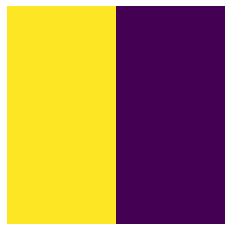

In [ ]:
show_image(Tiles[2])

In [ ]:
Rules = {
    0: {
        'L' : (2,3),
        'R' : (2,3),
        'U' : (1,3),
        'D' : (1,2,3),
    },
    1: {
        'L' : (1,3),
        'R' : (1,2,3),
        'U' : (0,3),
        'D' : (0,3),
    },
    2: {
        'L' : (0,1,3),
        'R' : (0,3),
        'U' : (0,3),
        'D' : (3,),
    },
    3: {
        'L' : (0,1,2),
        'R' : (0,1,2),
        'U' : (0,1,2),
        'D' : (0,1,2),
    },
}
verify_rules_2D(Rules)

In [ ]:
RulesMatrix = rules_to_np(Rules); RulesMatrix.shape

(4, 4, 4)

In [ ]:
RulesMatrix

array([[[False, False,  True,  True],
        [False, False,  True,  True],
        [False,  True, False,  True],
        [False,  True,  True,  True]],

       [[False,  True, False,  True],
        [False,  True,  True,  True],
        [ True, False, False,  True],
        [ True, False, False,  True]],

       [[ True,  True, False,  True],
        [ True, False, False,  True],
        [ True, False, False,  True],
        [False, False, False,  True]],

       [[ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True, False]]])

In [ ]:
verify_rules_matrix_2D(RulesMatrix)

In [ ]:
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))
AllWaves = [ImageFromPartialWaveFunction(N, M, W, TilesMatrix) for W in AllWaves]

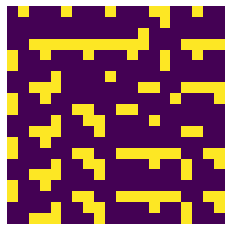

In [ ]:
show_image(AllWaves[-1])

<IPython.core.display.Javascript object>


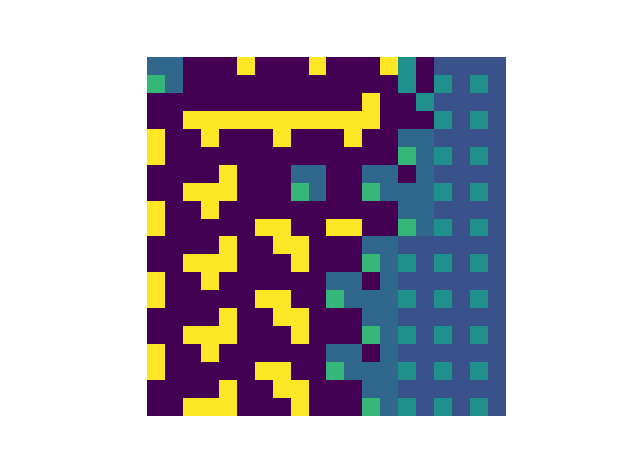

In [ ]:
animate_images(AllWaves, interval=100);

### Edge Based Automatic Rule Inference from existing Tiles

In [ ]:
def generate_triangle_masks(TileSize:int):
    "Returns 4 boolean Masks used for indexing into the different \"X\" quadrants of a Matrix of shape TileSize x TileSize."
    LowerTriangle = np.tri(TileSize, TileSize, 0, dtype=bool)
    UpperTriangle = LowerTriangle.T
    FlippedLowerTriangle = np.fliplr(LowerTriangle)
    FlippedUpperTriangle = np.fliplr(UpperTriangle)
    Up    = UpperTriangle & FlippedUpperTriangle
    Right = UpperTriangle & FlippedLowerTriangle
    Down  = LowerTriangle & FlippedLowerTriangle
    Left  = LowerTriangle & FlippedUpperTriangle
    return Up, Right, Down, Left

In [ ]:
def interpolate_colors(ColorA, ColorB): return ((ColorA + ColorB) // 2).astype(int)

In [ ]:
def generate_triangle_tile(TileSize:int, UpColor, RightColor, DownColor, LeftColor):
    "Generates a RGB image of shape TileSize x TileSize, with up to four different colours in an \"X\" shape."
    Up, Right, Down, Left = generate_triangle_masks(TileSize)
    Tile = np.zeros(shape=(TileSize, TileSize, 3), dtype=int)
    
    UpRightInterfaceColor   = interpolate_colors(UpColor  , RightColor)
    DownRightInterfaceColor = interpolate_colors(DownColor, RightColor)
    DownLeftInterfaceColor  = interpolate_colors(DownColor, LeftColor)
    UpLeftInterfaceColor    = interpolate_colors(UpColor  , LeftColor)
    
    Tile[Up]    = UpColor
    Tile[Right] = RightColor
    Tile[Down]  = DownColor
    Tile[Left]  = LeftColor
    
    Tile[Up & Right]   = UpRightInterfaceColor
    Tile[Down & Right] = DownRightInterfaceColor
    Tile[Down & Left]  = DownLeftInterfaceColor
    Tile[Up & Left]    = UpLeftInterfaceColor
    return Tile

https://en.wikipedia.org/wiki/Wang_tile  
https://en.wikipedia.org/wiki/Wang_tile#/media/File:Wang_11_tiles.svg  
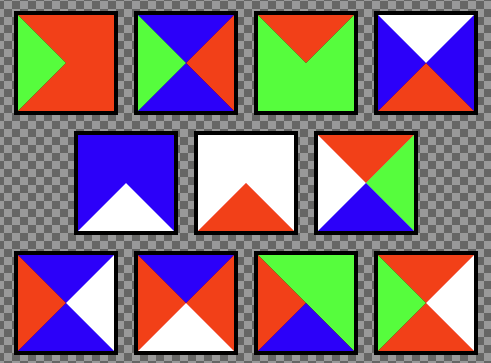

In [ ]:
WHITE = np.array([255, 255, 255])
RED   = np.array([255,   0,   0])
GREEN = np.array([  0, 255,   0])
BLUE  = np.array([  0,   0, 255])

In [ ]:
TileSize = 120
Tile01 = generate_triangle_tile(TileSize, RED  , RED  , RED  , GREEN)
Tile02 = generate_triangle_tile(TileSize, BLUE , RED  , BLUE , GREEN)
Tile03 = generate_triangle_tile(TileSize, RED  , GREEN, GREEN, GREEN)
Tile04 = generate_triangle_tile(TileSize, WHITE, BLUE , RED  , BLUE)
Tile05 = generate_triangle_tile(TileSize, BLUE , BLUE , WHITE, BLUE)
Tile06 = generate_triangle_tile(TileSize, WHITE, WHITE, RED  , WHITE)
Tile07 = generate_triangle_tile(TileSize, RED  , GREEN, BLUE , WHITE)
Tile08 = generate_triangle_tile(TileSize, BLUE , WHITE, BLUE , RED)
Tile09 = generate_triangle_tile(TileSize, BLUE , RED  , WHITE, RED)
Tile10 = generate_triangle_tile(TileSize, GREEN, GREEN, BLUE , RED)
Tile11 = generate_triangle_tile(TileSize, RED  , WHITE, RED  , GREEN)
TilesMatrix = np.array([Tile01, Tile02, Tile03, Tile04, Tile05, Tile06, Tile07, Tile08, Tile09, Tile10, Tile11])
TilesMatrix.shape

(11, 120, 120, 3)

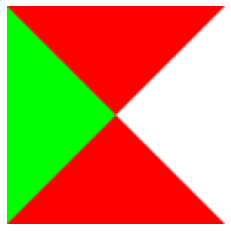

In [ ]:
show_image(Tile11)

In [ ]:
def get_edge_colors(Tile):
    "Returns the Color at the middle of each of the four edges."
    ShapeX, ShapeY, *_ = Tile.shape
    LeftColor  = Tile[ShapeX//2,         0]
    RightColor = Tile[ShapeX//2,        -1]
    UpColor    = Tile[        0, ShapeY//2]
    DownColor  = Tile[       -1, ShapeY//2]
    return LeftColor, RightColor, UpColor, DownColor

def infer_rules_from_edge_colors(TilesMatrix):
    "Creates the RulesMatrix from a given TilesMatrix, using the `get_edge_colors` condition.\n"\
    "The condition can technically be changed to something else and this would still work."
    # NOTE: RulesMatrix is created with the last two axis swapped, which is then corrected at the end.
    #       The reason for doing this is that this way we can do the checks for all four directions at once.
    RulesList = [] # NOTE: It's important this uses the ordering: 'L', 'R', 'U', 'D'
    for Tile in TilesMatrix:
        CurrentRules = []
        LeftColor, RightColor, UpColor, DownColor = get_edge_colors(Tile)
        for OtherTile in TilesMatrix:
            OtherLeftColor, OtherRightColor, OtherUpColor, OtherDownColor = get_edge_colors(OtherTile)            
            CurrentRules.append(np.array([LeftColor == OtherRightColor, RightColor == OtherLeftColor, 
                                            UpColor ==  OtherDownColor,  DownColor ==   OtherUpColor],
                                         dtype=bool).all(axis=-1))
        RulesList.append(CurrentRules)
    RulesMatrix = np.swapaxes(np.array(RulesList), -1, -2)
    return RulesMatrix

In [ ]:
RulesMatrix = infer_rules_from_edge_colors(TilesMatrix)
RulesMatrix.shape

(11, 4, 11)

In [ ]:
verify_rules_matrix_2D(RulesMatrix)

In [ ]:
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))

In [ ]:
AllWaves = [ImageFromPartialWaveFunction(N, M, W, TilesMatrix, int) for W in AllWaves]

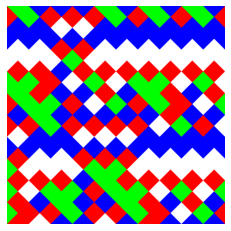

In [ ]:
show_image(AllWaves[-1], GridLines=0)

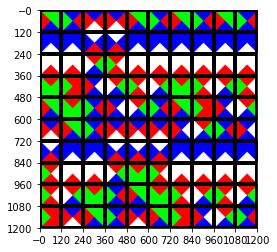

In [ ]:
show_image(AllWaves[-1], GridLines=120)

<IPython.core.display.Javascript object>


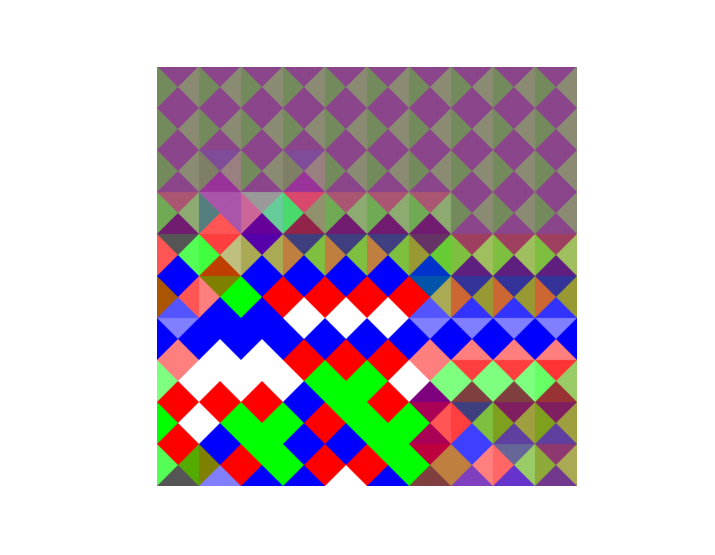

In [ ]:
save_animation('./data/WangTilesExample.gif', fps=10, dpi=150,
               anim=animate_images(AllWaves, GridLines=120*0, LineColor='black', interval=200))

### Automatic Tile and Rule Inference from Sample Image

https://github.com/mxgmn/WaveFunctionCollapse  
https://raw.githubusercontent.com/mxgmn/WaveFunctionCollapse/master/images/wfc.png

TODO: I feel rule inference can still be improved. The outputs dont look right a good amount of the time.  
Maybe that's just how it's supposed to look though.  
Also possible that it would need frequency data to get more accurate.  
Or there is a really subtle bug somewhere.  
Maybe the way I generate Tiles tends to produce artifacts in the ensuing output.

In [ ]:
def infer_tiles_and_rules(SampleImage, TileSize):
    "Creates the TilesMatrix as well as the RulesMatrix by analyzing the structure of a SampleImage."
    SampleX, SampleY, Channels = SampleImage.shape
    OverhangX = SampleX % TileSize
    OverhangY = SampleY % TileSize
    Tiles = list()
    Rules = defaultdict(lambda:{'L':[], 'R':[], 'U':[], 'D':[]})
    for OffsetX in range(TileSize):
        for OffsetY in range (TileSize):
            ToX    = (SampleX - OverhangX + OffsetX)
            if ToX > SampleX: ToX -= TileSize # Works as long as 0 <= OffsetX <= TileSize
            ToY    = (SampleY - OverhangY + OffsetY)
            if ToY > SampleY: ToY -= TileSize # Works as long as 0 <= OffsetY <= TileSize
            
            NrTilesX = (ToX - OffsetX) // TileSize
            NrTilesY = (ToY - OffsetY) // TileSize
            
            # NOTE: Get all Tiles making up the image, and store their relative coordinates to each other for rule inference.
            TileCoordinates = list()
            for (X, TileList) in enumerate(SampleImage[OffsetX:ToX, OffsetY:ToY].
                                           reshape(NrTilesX, TileSize, NrTilesY, TileSize, Channels).swapaxes(1, 2)):
                TileCoordinatesY = list()
                TileCoordinates.append(TileCoordinatesY)
                for (Y, Tile) in enumerate(TileList):
                    for (TileNr, ExistingTile) in enumerate(Tiles): # NOTE: Deduplicate Tiles
                        if np.allclose(Tile, ExistingTile):
                            TileCoordinatesY.append(TileNr)
                            break
                    else: # NOTE: This executes if we don't hit the break above
                        TileCoordinatesY.append(len(Tiles))
                        Tiles.append(Tile)
            # NOTE: Figure out neighbourhood rules for this Offset
            N = len(TileCoordinates)
            for (X, TileNrList) in enumerate(TileCoordinates):
                M = len(TileNrList)
                for (Y, TileNr) in enumerate(TileNrList):
                    # NOTE: These are NOT reversed directions. We're just listing out what tiles are next to the current tile.
                    TileRules = Rules[TileNr]
                    if (X - 1) >= 0      :  TileRules['U'].append(TileCoordinates[X - 1][Y    ])
                    if (X + 1) <= (N - 1):  TileRules['D'].append(TileCoordinates[X + 1][Y    ])
                    if (Y - 1) >= 0      :  TileRules['L'].append(TileCoordinates[X    ][Y - 1])
                    if (Y + 1) <= (M - 1):  TileRules['R'].append(TileCoordinates[X    ][Y + 1])
    TilesMatrix = np.array(Tiles)
    RulesMatrix = rules_to_np(Rules)
    verify_rules_matrix_2D(RulesMatrix)
    return TilesMatrix, RulesMatrix

In [ ]:
def load_sample_image(ImagePath:Path):
    "Load an Image from disk, and format it correctly for further use."
    SampleImage = cv2.imread(ImagePath.as_posix()).astype(int)
    # NOTE: For some reason cv loads colors as BGR in this case? Swap them here to get RGB.
    SampleImage[:, :, [0, 2]] = SampleImage[:, :, [2, 0]]
    return SampleImage

In [ ]:
def wrap_image(Image, TileSize:int):
    "Wraps around the edges of an image to produce a slightly bigger image."
    WrapAmount = TileSize - 1
    return np.pad(Image, pad_width=((WrapAmount, WrapAmount), (WrapAmount, WrapAmount), (0, 0)), mode='wrap')

#### Examples

These are examples using Sample images from [the original github](https://github.com/mxgmn/WaveFunctionCollapse).

In [ ]:
ROOT = Path('./data/Samples')
SamplePathCaves   = ROOT/'CavesSample.png'
SamplePathCity    = ROOT/'CitySample.png'
SamplePathFlowers = ROOT/'FlowersSample.png'
SamplePathHouses  = ROOT/'HousesSample.png'
SamplePathMaze    = ROOT/'MazeSample.png'

##### Caves

In [ ]:
SamplePath = SamplePathCaves
assert SamplePath.is_file()

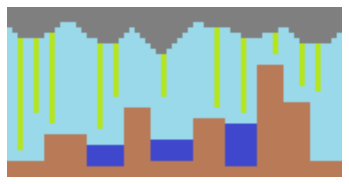

In [ ]:
SampleImage = load_sample_image(SamplePath)
show_image(SampleImage)

__What TileSize do you want to use?__  
- __Depending on the size of the image, and the size of features in the image, a different TileSize might be appropriate.__
- __Usually a TileSize of 2 or 3 is a good value.__

In [ ]:
TileSize = 3

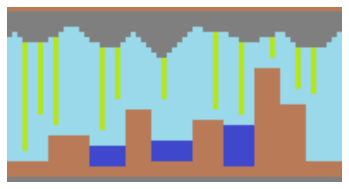

In [ ]:
WrappedSampleImage = wrap_image(SampleImage, TileSize)
show_image(WrappedSampleImage)

__Decide, shoud you use the wrapped version or the normal one?__  
- __Generally, any image with a sense of direction to it should probably not be wrapped.__  
- __Meaning if theres a "ground" and a "sky" in the image, wrapping it would result in those features becoming tangled.__

In [ ]:
SampleImage = WrappedSampleImage

In [ ]:
%%time
TilesMatrix, RulesMatrix = infer_tiles_and_rules(SampleImage, TileSize)
TilesMatrix.shape, RulesMatrix.shape

CPU times: total: 4.27 s
Wall time: 4.26 s


((96, 3, 3, 3), (96, 4, 96))

__Here you can check a few of the Tile, and maybe as an exercise, try finding them in the original image.__

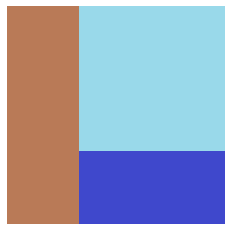

In [ ]:
show_image(TilesMatrix[45])

__The Rules Matrix lists out for each Tile, for each of the four directions, which Tile can be placed next to it, and which can't.__

In [ ]:
RulesMatrix

array([[[ True,  True, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [F

__Here we run the WaveFunctionCollapse Algorithm. You can decide how big you want the image to be.__
- __N and M control the size of the grid on which the Tiles are placed.__
- __So N, M = 20, 20 means the image will contain 20 x 20 Tiles. The amount of pixels depends on the TileSize.__

In [ ]:
%%time
N, M = 25, 80
AllWaves = list(WFC_2D(N, M, RulesMatrix))

CPU times: total: 2.06 s
Wall time: 2.09 s


In [ ]:
len(AllWaves)

239

In [ ]:
%%time
AllWaves = np.array([ImageFromPartialWaveFunction(N, M, W, TilesMatrix, AsType=int) for W in AllWaves])

CPU times: total: 31.4 s
Wall time: 31.5 s


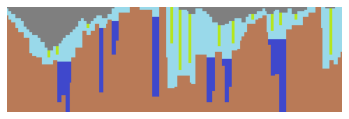

In [ ]:
show_image(AllWaves[-1])

<IPython.core.display.Javascript object>


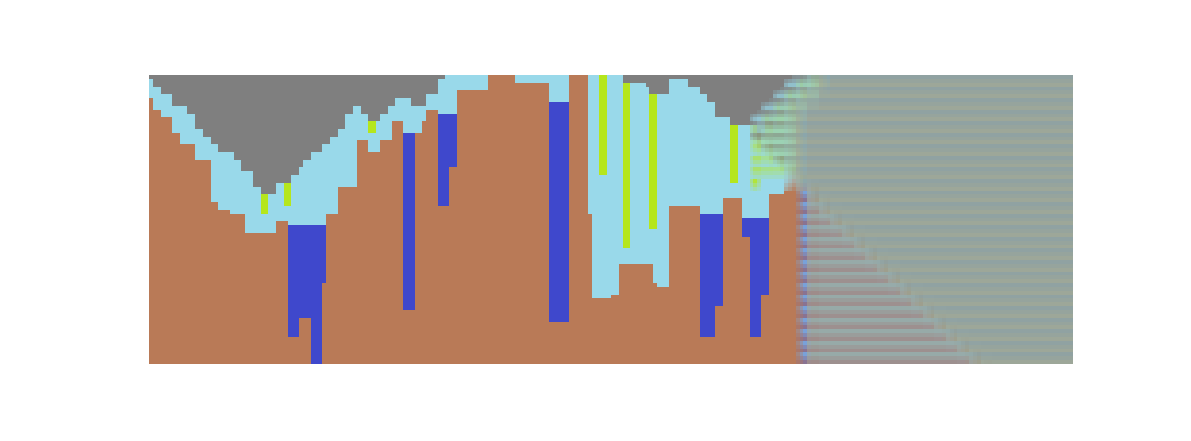

In [ ]:
save_animation('./data/CavesSample.gif', fps=25, dpi=350,
               anim=animate_images(AllWaves, interval=50));

In [ ]:
save_result(ROOT, SamplePath, TileSize, N, M, AllWaves)

WindowsPath('data/Samples/Results/CavesSample_3_25x80_1663531388538005700.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'CavesSample_3_20x90_1658134052042667900.npy')

##### City

In [ ]:
SamplePath = SamplePathCity
assert SamplePath.is_file()

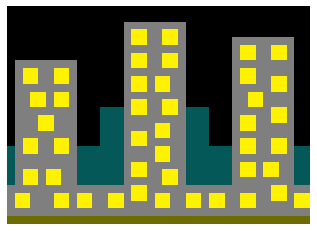

In [ ]:
SampleImage = load_sample_image(SamplePath)
show_image(SampleImage)

__What TileSize do you want to use?__  
- __Depending on the size of the image, and the size of features in the image, a different TileSize might be appropriate.__
- __Usually a TileSize of 2 or 3 is a good value.__

In [ ]:
TileSize = 3

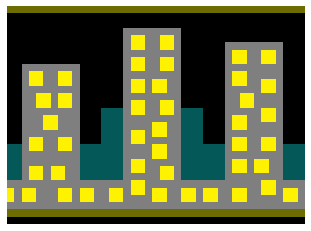

In [ ]:
WrappedSampleImage = wrap_image(SampleImage, TileSize)
show_image(WrappedSampleImage)

__Decide, shoud you use the wrapped version or the normal one?__  
- __Generally, any image with a sense of direction to it should probably not be wrapped.__  
- __Meaning if theres a "ground" and a "sky" in the image, wrapping it would result in those features becoming tangled.__

In [ ]:
SampleImage = WrappedSampleImage

In [ ]:
%%time
TilesMatrix, RulesMatrix = infer_tiles_and_rules(SampleImage, TileSize)
TilesMatrix.shape, RulesMatrix.shape

CPU times: total: 1.98 s
Wall time: 1.97 s


((88, 3, 3, 3), (88, 4, 88))

__Here you can check a few of the Tile, and maybe as an exercise, try finding them in the original image.__

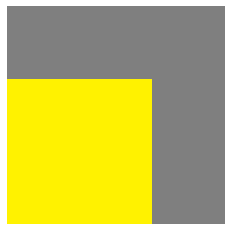

In [ ]:
show_image(TilesMatrix[27])

__The Rules Matrix lists out for each Tile, for each of the four directions, which Tile can be placed next to it, and which can't.__

In [ ]:
RulesMatrix[0]

array([[ True,  True,  True, False, False,  True, False, False,  True,
        False,  True,  True, False, False, False, False, False, False,
         True, False,  True, False, False,  True, False, False, False,
        False, False, False,  True, False,  True, False, False,  True,
        False,  True, False, False, False, False, False, False, False,
        False,  True,  True, False,  True, False, False, False, False,
        False, False,  True, False, False, False,  True,  True, False,
         True,  True, False,  True, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [ True,  True, False,  True, False,  True, False, False, False,
         True,  True, False,  True, False, False, False,  True, False,
        False,  True, False,  True, False, False,  True,  True, False,
        False, False, False,  True, False, False,  True, False,  True,
        False, Fals

__Here we run the WaveFunctionCollapse Algorithm. You can decide how big you want the image to be.__
- __N and M control the size of the grid on which the Tiles are placed.__
- __So N, M = 20, 20 means the image will contain 20 x 20 Tiles. The amount of pixels depends on the TileSize.__

In [ ]:
%%time
N, M = 25, 80
AllWaves = list(WFC_2D(N, M, RulesMatrix))

CPU times: total: 2.3 s
Wall time: 2.3 s


In [ ]:
len(AllWaves)

410

In [ ]:
%%time
AllWaves = np.array([ImageFromPartialWaveFunction(N, M, W, TilesMatrix, AsType=int) for W in AllWaves])

CPU times: total: 1min 18s
Wall time: 1min 18s


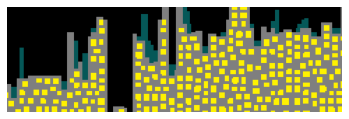

In [ ]:
show_image(AllWaves[-1])

<IPython.core.display.Javascript object>


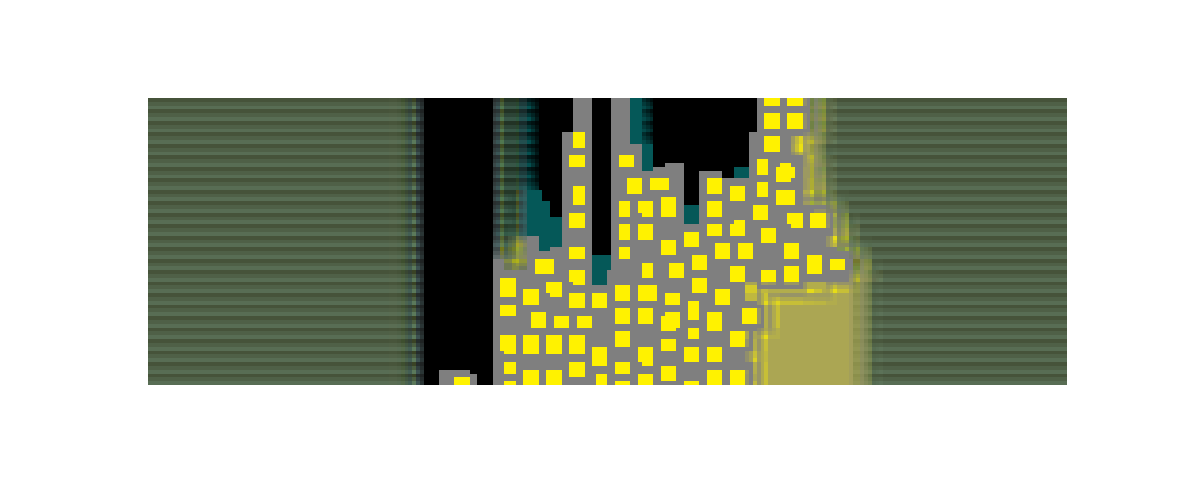

In [ ]:
save_animation('./data/CitySample.gif', fps=60, dpi=350,
               anim=animate_images(AllWaves, interval=10));

In [ ]:
save_result(ROOT, SamplePath, TileSize, N, M, AllWaves)

WindowsPath('data/Samples/Results/CitySample_3_20x70_1658135100059621800.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'CitySample_3_30x70_1658134998075530200.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'CitySample_3_20x70_1658135100059621800.npy')

##### Flowers

In [ ]:
SamplePath = SamplePathFlowers
assert SamplePath.is_file()

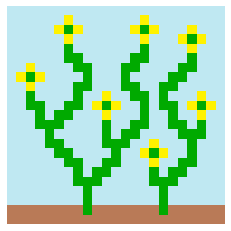

In [ ]:
SampleImage = load_sample_image(SamplePath)
show_image(SampleImage)

In [ ]:
SampleImage.shape

(46, 46, 3)

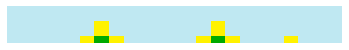

In [ ]:
show_image(SampleImage[0:5, :])

__What TileSize do you want to use?__  
- __Depending on the size of the image, and the size of features in the image, a different TileSize might be appropriate.__
- __Usually a TileSize of 2 or 3 is a good value.__

In [ ]:
TileSize = 6

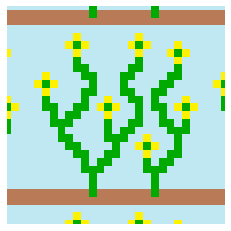

In [ ]:
WrappedSampleImage = wrap_image(SampleImage, TileSize)
show_image(WrappedSampleImage)

__Decide, shoud you use the wrapped version or the normal one?__  
- __Generally, any image with a sense of direction to it should probably not be wrapped.__  
- __Meaning if theres a "ground" and a "sky" in the image, wrapping it would result in those features becoming tangled.__

In [ ]:
SampleImage = WrappedSampleImage

In [ ]:
%%time
TilesMatrix, RulesMatrix = infer_tiles_and_rules(SampleImage, TileSize)
TilesMatrix.shape, RulesMatrix.shape

CPU times: total: 11.1 s
Wall time: 11.1 s


((660, 6, 6, 3), (660, 4, 660))

__Here you can check a few of the Tile, and maybe as an exercise, try finding them in the original image.__

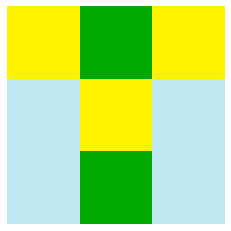

In [ ]:
show_image(TilesMatrix[8])

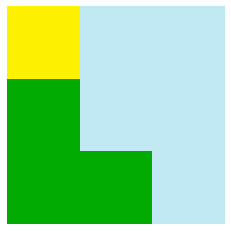

In [ ]:
show_image(TilesMatrix[6])

__The Rules Matrix lists out for each Tile, for each of the four directions, which Tile can be placed next to it, and which can't.__

In [ ]:
RulesMatrix[0]

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False],
       [ True,  True,  True, ..., False, False, False]])

__Here we run the WaveFunctionCollapse Algorithm. You can decide how big you want the image to be.__
- __N and M control the size of the grid on which the Tiles are placed.__
- __So N, M = 20, 20 means the image will contain 20 x 20 Tiles. The amount of pixels depends on the TileSize.__

In [ ]:
%%time
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))

CPU times: total: 469 ms
Wall time: 467 ms


In [ ]:
len(AllWaves)

26

In [ ]:
%%time
AllWaves = np.array([ImageFromPartialWaveFunction(N, M, W, TilesMatrix, AsType=int) for W in AllWaves])

CPU times: total: 78.1 ms
Wall time: 74.1 ms


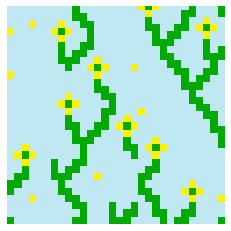

In [ ]:
show_image(AllWaves[-1])

<IPython.core.display.Javascript object>


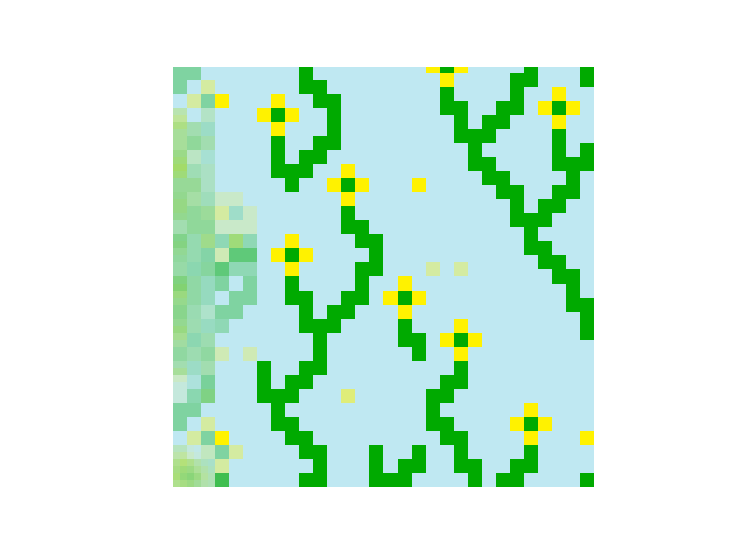

In [ ]:
save_animation('./data/FlowersSample.gif', fps=15, dpi=350,
               anim=animate_images(AllWaves, interval=100));

In [ ]:
save_result(ROOT, SamplePath, TileSize, N, M, AllWaves)

WindowsPath('data/Samples/Results/FlowersSample_6_10x10_1663535563225217100.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'FlowersSample_3_40x40_1658135276045787700.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'FlowersSample_3_10x10_1658135319302773000.npy')

##### Houses

In [ ]:
SamplePath = SamplePathHouses
assert SamplePath.is_file()

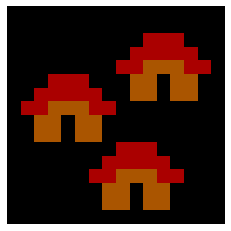

In [ ]:
SampleImage = load_sample_image(SamplePath)
show_image(SampleImage)

__What TileSize do you want to use?__  
- __Depending on the size of the image, and the size of features in the image, a different TileSize might be appropriate.__
- __Usually a TileSize of 2 or 3 is a good value.__

In [ ]:
TileSize = 4

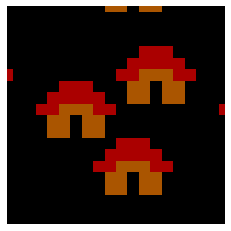

In [ ]:
WrappedSampleImage = wrap_image(SampleImage, TileSize)
show_image(WrappedSampleImage)

__Decide, shoud you use the wrapped version or the normal one?__  
- __Generally, any image with a sense of direction to it should probably not be wrapped.__  
- __Meaning if theres a "ground" and a "sky" in the image, wrapping it would result in those features becoming tangled.__

In [ ]:
SampleImage = WrappedSampleImage

In [ ]:
%%time
TilesMatrix, RulesMatrix = infer_tiles_and_rules(SampleImage, TileSize)
TilesMatrix.shape, RulesMatrix.shape

CPU times: total: 1.03 s
Wall time: 1.02 s


((135, 4, 4, 3), (135, 4, 135))

__Here you can check a few of the Tile, and maybe as an exercise, try finding them in the original image.__

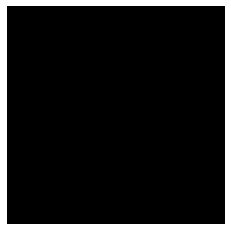

In [ ]:
show_image(TilesMatrix[0])

__The Rules Matrix lists out for each Tile, for each of the four directions, which Tile can be placed next to it, and which can't.__

In [ ]:
RulesMatrix[0]

array([[ True, False,  True, False, False, False, False, False,  True,
        False, False, False,  True,  True,  True,  True, False, False,
         True,  True, False, False,  True, False,  True, False, False,
        False,  True, False, False, False, False,  True,  True,  True,
        False, False,  True, False, False,  True, False, False,  True,
        False, False, False, False, False, False,  True, False,  True,
        False,  True, False, False,  True, False, False,  True, False,
        False,  True, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False,  True, False, False,
         True,  True, False, False,  True,  True, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False,  True, False, False,  True, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False, False,  True, False, False,
      

__Here we run the WaveFunctionCollapse Algorithm. You can decide how big you want the image to be.__
- __N and M control the size of the grid on which the Tiles are placed.__
- __So N, M = 20, 20 means the image will contain 20 x 20 Tiles. The amount of pixels depends on the TileSize.__

In [ ]:
%%time
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))

CPU times: total: 46.9 ms
Wall time: 37.3 ms


In [ ]:
len(AllWaves)

12

In [ ]:
%%time
AllWaves = np.array([ImageFromPartialWaveFunction(N, M, W, TilesMatrix, AsType=int) for W in AllWaves])

CPU times: total: 15.6 ms
Wall time: 24 ms


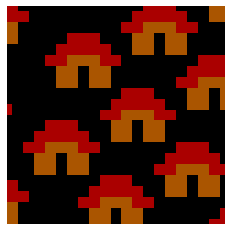

In [ ]:
show_image(AllWaves[-1])

<IPython.core.display.Javascript object>


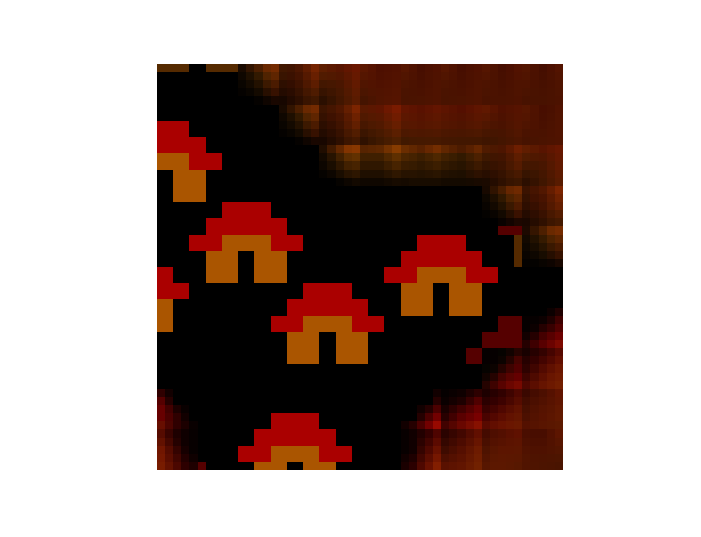

In [ ]:
animate_images(AllWaves, interval=100);

In [ ]:
save_result(ROOT, SamplePath, TileSize, N, M, AllWaves)

WindowsPath('data/Samples/Results/HousesSample_2_10x10_1658135452957021300.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'HousesSample_3_10x10_1658135397201295100.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'HousesSample_2_10x10_1658135452957021300.npy')

##### Maze

In [ ]:
SamplePath = SamplePathMaze
assert SamplePath.is_file()

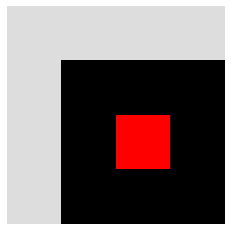

In [ ]:
SampleImage = load_sample_image(SamplePath)
show_image(SampleImage)

__What TileSize do you want to use?__  
- __Depending on the size of the image, and the size of features in the image, a different TileSize might be appropriate.__
- __Usually a TileSize of 2 or 3 is a good value.__

In [ ]:
TileSize = 2

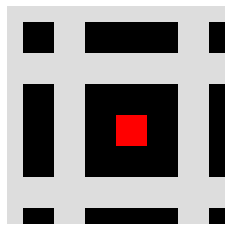

In [ ]:
WrappedSampleImage = wrap_image(SampleImage, TileSize)
show_image(WrappedSampleImage)

__Decide, shoud you use the wrapped version or the normal one?__  
- __Generally, any image with a sense of direction to it should probably not be wrapped.__  
- __Meaning if theres a "ground" and a "sky" in the image, wrapping it would result in those features becoming tangled.__

In [ ]:
SampleImage = WrappedSampleImage

In [ ]:
%%time
TilesMatrix, RulesMatrix = infer_tiles_and_rules(SampleImage, TileSize)
TilesMatrix.shape, RulesMatrix.shape

CPU times: total: 46.9 ms
Wall time: 43.5 ms


((19, 2, 2, 3), (19, 4, 19))

__Here you can check a few of the Tile, and maybe as an exercise, try finding them in the original image.__

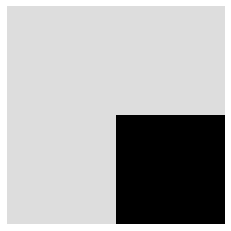

In [ ]:
show_image(TilesMatrix[0])

__The Rules Matrix lists out for each Tile, for each of the four directions, which Tile can be placed next to it, and which can't.__

In [ ]:
RulesMatrix[0]

array([[False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False]])

__Here we run the WaveFunctionCollapse Algorithm. You can decide how big you want the image to be.__
- __N and M control the size of the grid on which the Tiles are placed.__
- __So N, M = 20, 20 means the image will contain 20 x 20 Tiles. The amount of pixels depends on the TileSize.__

In [ ]:
%%time
N, M = 10, 10
AllWaves = list(WFC_2D(N, M, RulesMatrix))

CPU times: total: 78.1 ms
Wall time: 83.5 ms


In [ ]:
len(AllWaves)

47

In [ ]:
%%time
AllWaves = np.array([ImageFromPartialWaveFunction(N, M, W, TilesMatrix, AsType=int) for W in AllWaves])

CPU times: total: 93.8 ms
Wall time: 88.5 ms


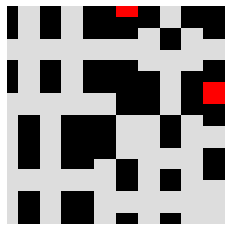

In [ ]:
show_image(AllWaves[-1])

<IPython.core.display.Javascript object>


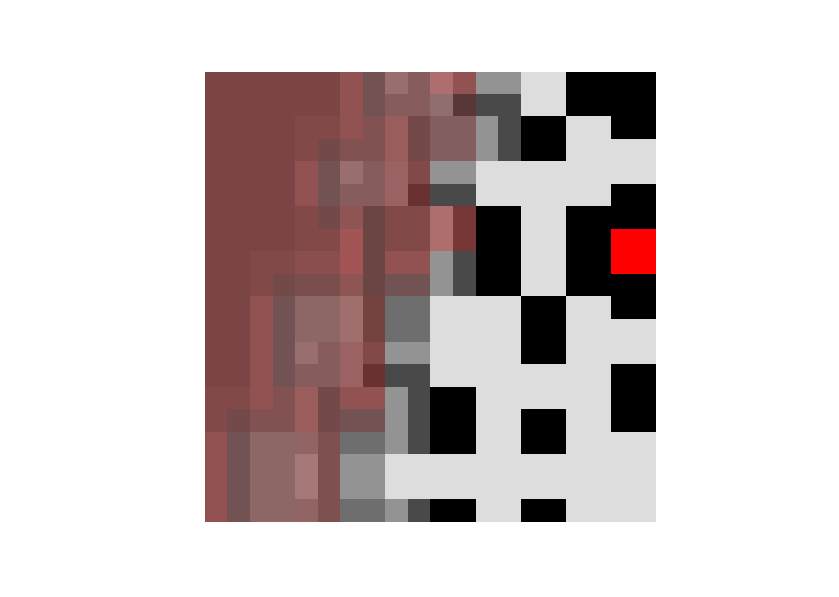

In [ ]:
animate_images(AllWaves, interval=100);

In [ ]:
save_result(ROOT, SamplePath, TileSize, N, M, AllWaves)

WindowsPath('data/Samples/Results/MazeSample_2_10x10_1658135626351874100.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'MazeSample_2_10x10_1658135550396456700.npy')

In [ ]:
AllWaves = np.load(ROOT/'Results'/'MazeSample_2_10x10_1658135626351874100.npy')

##### More Maze Examples

<IPython.core.display.Javascript object>


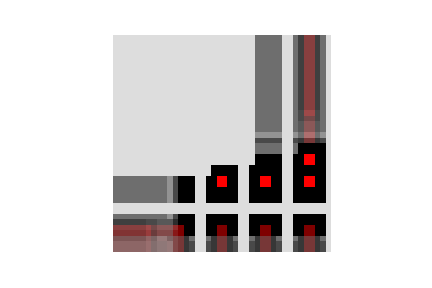

In [ ]:
animate_images(AllWaves);

```python
# NOT DEDUPLICATED
show_image(assemble_tiles(TilesMatrix.reshape(6, 6, 3, 3, 3), GridLines=TileSize, LineColor='white')
```
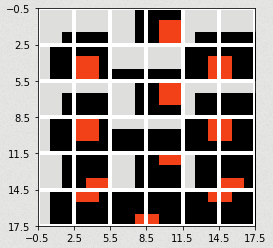

```python
# DEDUPLICATED
# Padding to make a square number of tiles
TilesMatrixPadded = np.stack([*TilesMatrix, TilesMatrix[-1]], axis=0)
show_image(assemble_tiles(TilesMatrixPadded.reshape(5, 5, 3, 3, 3)), GridLines=TileSize, LineColor='white')
```
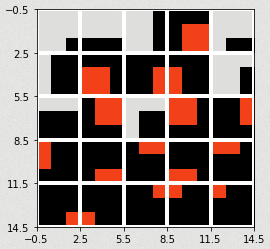

This code was used to create the Tile visualizations above  
```python
def foo(SampleImage, TileSize, DEDUPLICATE:bool):
    OverhangX = SampleX % TileSize
    OverhangY = SampleY % TileSize
    Tiles = list()
    for OffsetX in range(TileSize):
        for OffsetY in range (TileSize):
            ToX    = SampleX - OverhangX + OffsetX
            if ToX > SampleX: ToX -= TileSize # Works as long as 0 <= Offset <= TileSize
            ToY    = SampleY - OverhangY + OffsetY
            if ToY > SampleY: ToY -= TileSize # Works as long as 0 <= Offset <= TileSize

            NrTilesX = (ToX - OffsetX) // TileSize
            NrTilesY = (ToY - OffsetY) // TileSize

            for TileList in SampleImage[OffsetX:ToX, OffsetY:ToY].
                            reshape(NrTilesX, TileSize, NrTilesY, TileSize, Channels).swapaxes(1, 2):
                if DEDUPLICATE:
                    for Tile in TileList:
                        for ExistingTile in Tiles:
                            if np.allclose(Tile, ExistingTile): break
                        else: Tiles.append(Tile)
                else: Tiles.extend(TileList)
    TilesMatrix = np.array(Tiles)
    return TilesMatrix
```